In [1]:
import itertools
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/Users/hwangtaeeon/Documents/GitHub/Data-AI/Care_Duration_Prediction_Model/Data_Preprocessing/Regular_Expression/final_data.csv')

# 고유 병명 리스트
diseases = df['병명'].tolist()

# 각 특성별 범주 정의
genders = ['성별_남자', '성별_여자']
surgery_status = ['수술여부_아니오', '수술여부_예']
age_groups = ['연령대_30세미만', '연령대_30-39세', '연령대_40-49세', '연령대_50-59세', '연령대_60세이상']
regions = ['지역본부_서울지역', '지역본부_부산지역', '지역본부_대구지역', '지역본부_경인지역', '지역본부_광주지역', '지역본부_대전지역']

In [4]:
# 모든 조합 생성 (병명 포함 총 5개의 입력)
input_combinations = list(itertools.product(diseases, genders, surgery_status, age_groups, regions))

# 전처리된 데이터를 저장할 리스트
processed_data = []

# 조합마다 평균 예측값 계산
for disease, gender, surgery, age, region in input_combinations:
    row = df[df['병명'] == disease]
    if row.empty:
        continue
    values = row[[gender, surgery, age, region]].values[0]
    if pd.isnull(values).any():
        continue  # 결측값 포함 시 제외
    mean_value = values.mean()
    processed_data.append([disease, gender, surgery, age, region, mean_value])

# 데이터프레임으로 변환
processed_df = pd.DataFrame(processed_data, columns=['병명', '성별', '수술여부', '연령대', '지역본부', '예측값'])

processed_df.to_csv('processed_prediction_data.csv', index=False)

In [5]:
# 📌 Label Encoding
encoders = {}
X = pd.DataFrame()
for col in ['병명', '성별', '수술여부', '연령대', '지역본부']:
    enc = LabelEncoder()
    X[col] = enc.fit_transform(processed_df[col])
    encoders[col] = enc

y = processed_df['예측값'].values

In [6]:
# 📌 Stratified split
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=X['병명'], random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=X_trainval['병명'], random_state=42)

In [7]:
# 📌 TensorDataset
def to_tensor(x, y):
    return TensorDataset(torch.tensor(x.values, dtype=torch.long), torch.tensor(y, dtype=torch.float32))

train_loader = DataLoader(to_tensor(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(to_tensor(X_val, y_val), batch_size=64)
test_loader = DataLoader(to_tensor(X_test, y_test), batch_size=64)

In [8]:
# 📌 MLP Model
class MLPRegressor(nn.Module):
    def __init__(self, input_dims, embed_dim=8):
        super().__init__()
        self.embeds = nn.ModuleList([
            nn.Embedding(dim, embed_dim) for dim in input_dims
        ])
        self.fc1 = nn.Linear(embed_dim * len(input_dims), 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.cat([emb(x[:, i]) for i, emb in enumerate(self.embeds)], dim=1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.fc2(x))
        return self.out(x).squeeze()

In [9]:

# 📌 Model Setup
input_dims = [X[col].nunique() for col in X.columns]
model = MLPRegressor(input_dims)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=True)
criterion = nn.MSELoss()

/Users/hwangtaeeon/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: train=9130.4187, val=673.6109
Epoch 2: train=564.2649, val=194.9404
Epoch 3: train=505.2710, val=174.7947
Epoch 4: train=513.2533, val=185.9086
Epoch 5: train=436.0656, val=167.6485
Epoch 6: train=424.1050, val=205.7336
Epoch 7: train=392.5786, val=250.2571
Epoch 8: train=477.3354, val=180.5891
Epoch 9: train=436.3444, val=170.9906
Epoch 10: train=391.5081, val=200.6910
Epoch 11: train=399.4203, val=149.9118
Epoch 12: train=357.0564, val=148.2228
Epoch 13: train=349.5876, val=151.8021
Epoch 14: train=425.0921, val=197.2472
Epoch 15: train=363.9675, val=131.0702
Epoch 16: train=362.3606, val=171.1769
Epoch 17: train=375.5329, val=161.9001
Epoch 18: train=356.3226, val=128.5103
Epoch 19: train=389.1138, val=191.6335
Epoch 20: train=402.3093, val=130.6819
Epoch 21: train=333.6455, val=126.4293
Epoch 22: train=381.1986, val=192.8177
Epoch 23: train=366.2653, val=175.3568
Epoch 24: train=366.1138, val=174.9995
Epoch 25: train=341.9327, val=132.0108
Epoch 26: train=328.5581, val=144

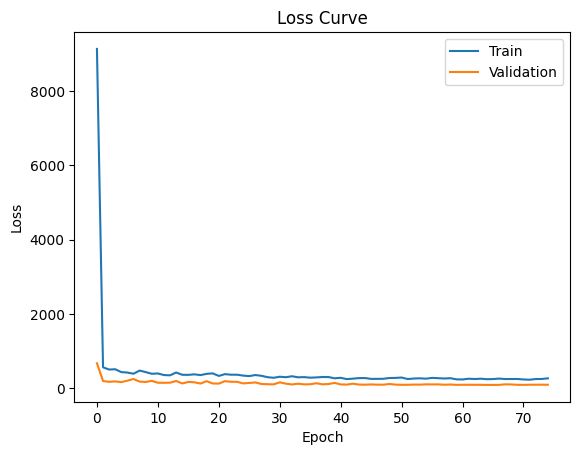

In [10]:
# 📌 Training Loop with Early Stopping
best_val_loss = float('inf')
early_stop_counter = 0
train_losses, val_losses = [], []

for epoch in range(1000):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(xb)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item() * len(xb)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}: train={train_loss:.4f}, val={val_loss:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= 10:
            print("✅ Early stopping!")
            break

# 📈 Loss Curve
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()

/var/folders/vw/vz_f7h9d5tzbfgcgfvhtjwzh0000gn/T/ipykernel_52823/1471704592.py:22: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vw/vz_f7h9d5tzbfgcgfvhtjwzh0000gn/T/ipykernel_52823/1471704592.py:22: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vw/vz_f7h9d5tzbfgcgfvhtjwzh0000gn/T/ipykernel_52823/1471704592.py:22: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/hwangtaeeon/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hwangtaeeon/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(byte

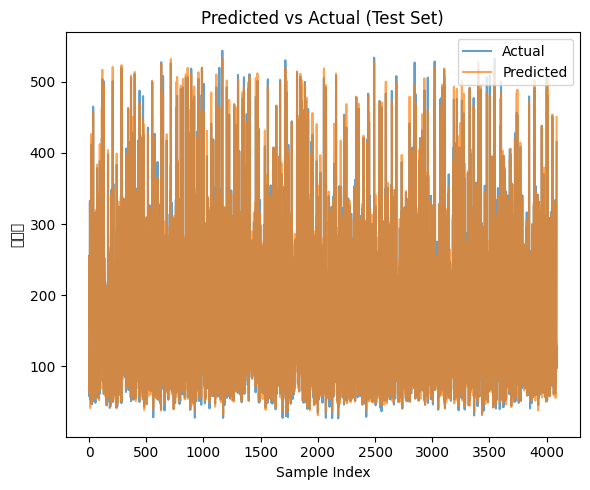

In [11]:
# 📌 Test Set Evaluation & Visualization
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

predictions = []
actuals = []

with torch.no_grad():
    for xb, yb in test_loader:
        pred = model(xb)
        predictions.extend(pred.tolist())
        actuals.extend(yb.tolist())

# 📈 예측값 vs 실제값 시각화
plt.figure(figsize=(6, 5))
plt.plot(actuals, label='Actual', alpha=0.7)
plt.plot(predictions, label='Predicted', alpha=0.7)
plt.title('Predicted vs Actual (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('예측값')
plt.legend()
plt.tight_layout()
plt.show()